In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.8/413.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.

In [2]:
!nvidia-smi

Fri Jun 28 17:06:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [5]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [6]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

### Load data

Link: https://huggingface.co/datasets/samsum

In [ ]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][1]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


# Evaluating PEGASUS on SAMSum

In [ ]:
dataset_samsum['test'][0]['dialogue']

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [ ]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )

print(pipe_out)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [ ]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [ ]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8)

<ipython-input-27-388971e09d3a>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


100%|██████████| 103/103 [19:17<00:00, 11.24s/it]


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015564,0.000294,0.015572,0.015588


# Histogram

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


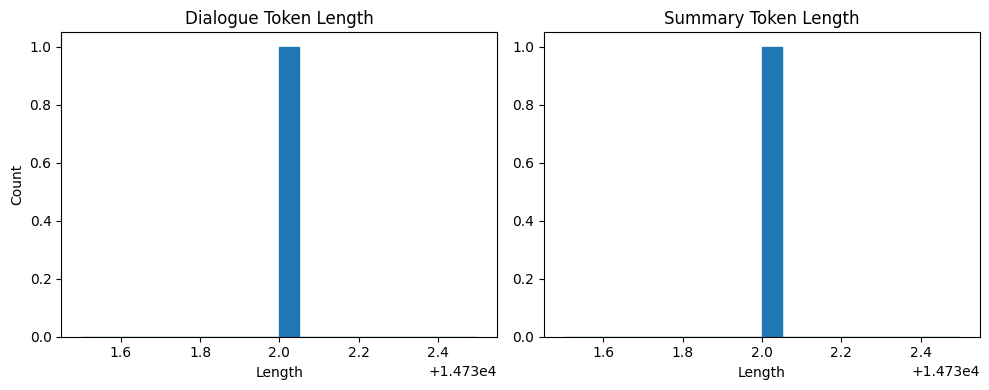

In [ ]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/summarization

/content/drive/MyDrive/Colab Notebooks/summarization


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 9.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:

trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()


Step,Training Loss,Validation Loss
500,1.659900,1.483296


TrainOutput(global_step=920, training_loss=1.8251974468645842, metrics={'train_runtime': 3110.8808, 'train_samples_per_second': 4.736, 'train_steps_per_second': 0.296, 'total_flos': 5528248038285312.0, 'train_loss': 1.8251974468645842, 'epoch': 0.9991854466467553})

In [ ]:
pwd

'/content/drive/MyDrive/Colab Notebooks/summarization'

In [ ]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 410/410 [13:08<00:00,  1.92s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018618,0.000297,0.018493,0.018518


In [ ]:
## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


In [ ]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [ ]:
!pip install huggingface_hub -q

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write)

In [ ]:
from huggingface_hub import HfApi

In [ ]:
repo_name = "anmZahid/Coversational_text_summarize"

In [ ]:
model_pegasus.push_to_hub(repo_name, use_auth_token=True)

# Push the tokenizer to the same repository
tokenizer.push_to_hub(repo_name, use_auth_token=True)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:836: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anmZahid/Coversational_text_summarize/commit/5b11fab348abf0e636cde87e9351847a08fe72fb', commit_message='Upload tokenizer', commit_description='', oid='5b11fab348abf0e636cde87e9351847a08fe72fb', pr_url=None, pr_revision=None, pr_num=None)

# Test

In [ ]:
dataset_samsum = load_dataset("samsum")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [ ]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

In [ ]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


In [ ]:
conversation = """
Orthee: Hi! How have you been?
zahid: I've been good, thanks. How about you?
Orthee: I'm doing well, just been busy with work.
zahid : Same here. Work has been quite hectic lately.
Orthee: Yeah, I can relate. Any plans for the weekend?
zahid: Not much, just planning to relax and maybe catch up on some reading. You?
Orthee: Sounds nice. I might go for a hike if the weather is good.
zahid: That sounds great. Hope you have a good time!
Orthee: Thanks! Enjoy your weekend too!
zahid: Will do. Talk to you later!
Orthee: Bye!
zahid: Bye!
"""

print("\nModel Summary:")
print(pipe(conversation, **gen_kwargs)[0]["summary_text"])


Model Summary:
Orthee andzahid have been busy with work lately. They are planning to relax and catch up on some reading at the weekend. Orthee might go for a hike if the weather is good.
